## CS441: Applied ML - HW 1

### Parts 1-2: MNIST

Include all the code for generating MNIST results below

In [2]:
# initialization code
import numpy as np
from keras.datasets import mnist
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats
import faiss
import time


def load_mnist():
  '''
  Loads, reshapes, and normalizes the data
  '''
  (x_train, y_train), (x_test, y_test) = mnist.load_data() # loads MNIST data
  x_train = np.reshape(x_train, (len(x_train), 28*28))  # reformat to 768-d vectors
  x_test = np.reshape(x_test, (len(x_test), 28*28))
  maxval = x_train.max()
  x_train = x_train/maxval  # normalize values to range from 0 to 1
  x_test = x_test/maxval
  return (x_train, y_train), (x_test, y_test)

def display_mnist(x, subplot_rows=1, subplot_cols=1):
  '''
  Displays one or more examples in a row or a grid
  '''
  if subplot_rows>1 or subplot_cols>1:
    fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(15,15))
    for i in np.arange(len(x)):
      ax[i].imshow(np.reshape(x[i], (28,28)), cmap='gray')
      ax[i].axis('off')
  else:
      plt.imshow(np.reshape(x, (28,28)), cmap='gray')
      plt.axis('off')
  plt.show()

2024-02-05 14:55:46.910061: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-05 14:55:46.910141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-05 14:55:46.912560: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-05 14:55:46.922567: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-05 14:55:47.603859: W tensorflow/compiler/tf2

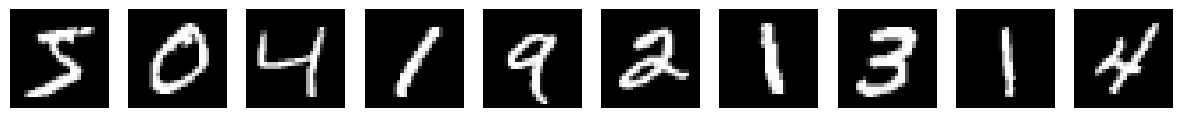

Total size: train=60000, test =10000


In [3]:
# example of using MNIST load and display  functions
(x_train, y_train), (x_test, y_test) = load_mnist()
display_mnist(x_train[:10],1,10)
print('Total size: train={}, test ={}'.format(len(x_train), len(x_test)))

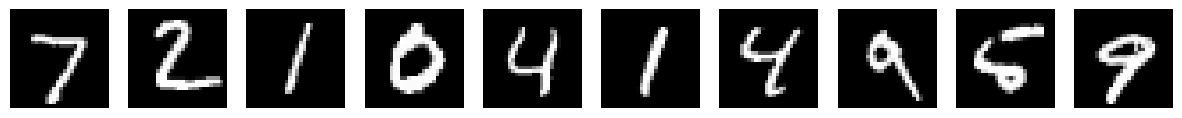

In [3]:
display_mnist(x_test[:10],1,10)

In [4]:
x_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

1. Retrieval, Clustering, and NN Classification

In [4]:
# Retrieval

def get_nearest(X_query, X):
    ''' Return the index of the sample in X that is closest to X_query according
      to L2 distance '''
    dist = np.square(X_query - X).sum(axis=-1)
    return np.argmin(dist)


j = get_nearest(x_test[0], x_train)
print(j)

j = get_nearest(x_test[1], x_train)
print(j)

53843
28882


Iteration 1


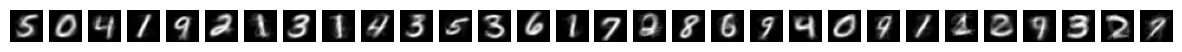

Iteration 2


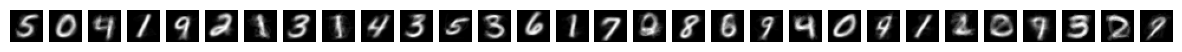

Iteration 3


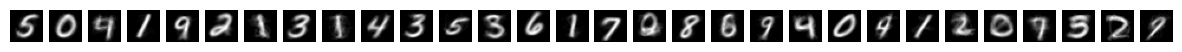

Iteration 4


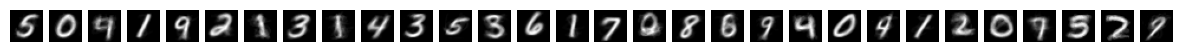

Iteration 5


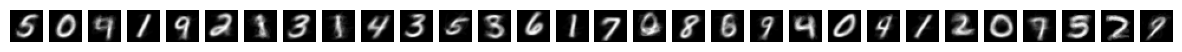

Iteration 6


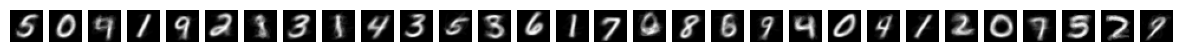

Iteration 7


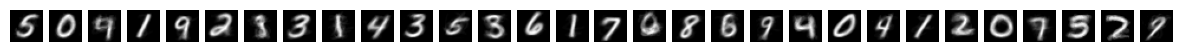

Iteration 8


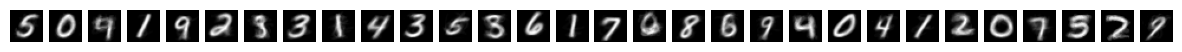

Iteration 9


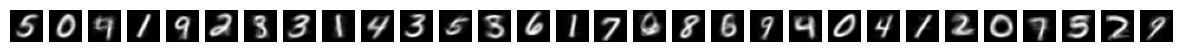

Iteration 10


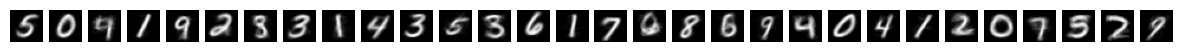

In [5]:
# K-means

def kmeans(X, K, niter=10):
  '''
  Starting with the first K samples in X as cluster centers, iteratively assign each
  point to the nearest cluster and compute the mean of each cluster.
  Input: X[i] is the ith sample, K is the number of clusters, niter is the number of iterations
  Output: K cluster centers
  '''
  # TO DO -- add code to display cluster centers at each iteration also
  centers = X[:K].copy()
  for i in range(1,1+niter):
    print(f"Iteration {i}")
    clusters = [[] for _ in range(K)]
    for x in X:
      idx = get_nearest(x, centers)
      clusters[idx].append(x)
    for c in range(K):
      centers[c] = np.stack(clusters[c]).mean(axis=0)
    display_mnist(centers, 1, K)

K=30
centers = kmeans(x_train[:1000], K)



In [6]:
# 1-NN
errors = []
for i,x in enumerate(x_test[:100]):
  idx = get_nearest(x, x_train[:10000])
  errors.append(y_train[idx] != y_test[i])
print(np.mean(errors))


0.08


2. Make it fast

In [11]:
# install libraries you need for part 2
!apt install libomp-dev
!pip install faiss-cpu
import faiss
import time

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 21.9 MB/s eta 0:00:0000:0100:01


In [6]:
  # retrieval

# TO DO (check that you're using FAISS correctly)
index = faiss.IndexFlatL2(x_train.shape[1])
index.add(x_train) # add the data
dist, idx = index.search(x_test[:2],1)
print(idx)

[[53843]
 [28882]]


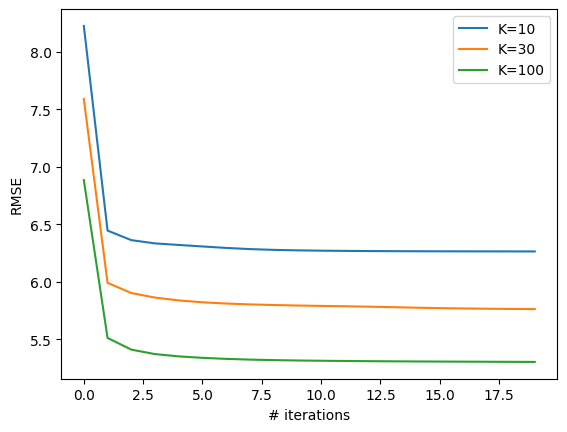

In [7]:
import faiss
import numpy as np
import matplotlib.pyplot as plt

def kmeans_fast(X, K, niter=10):
    X = X.astype(np.float32)
    d = X.shape[1]
    cluster_centers = X[:K].copy()
    index = faiss.IndexFlatL2(d)

    rmse_list = []

    for i in range(niter):
        index.reset()
        index.add(cluster_centers)
        D, I = index.search(X, 1)  # D is the squared distances
        rmse = np.sqrt(np.mean(D))  # Compute the RMSE from the squared distances
        rmse_list.append(rmse)

        for k in range(K):
            points_in_cluster = X[I.squeeze() == k]
            if len(points_in_cluster) > 0:
                cluster_centers[k] = np.mean(points_in_cluster, axis=0)

    return cluster_centers, rmse_list

# Assuming x_train is defined and is the correct input data
# You can now run the kmeans_fast function and plot the results
K = 10
centers, rmse = kmeans_fast(x_train, K, niter=20)
plt.plot(np.arange(len(rmse)), rmse, label='K=10')

K=30
centers, rmse = kmeans_fast(x_train, K, niter=20)
plt.plot(np.arange(len(rmse)), rmse, label='K=30')

K=100
centers, rmse = kmeans_fast(x_train, K, niter=20)
plt.plot(np.arange(len(rmse)), rmse, label='K=100')
plt.legend(), plt.ylabel('RMSE'), plt.xlabel('# iterations')
plt.show()


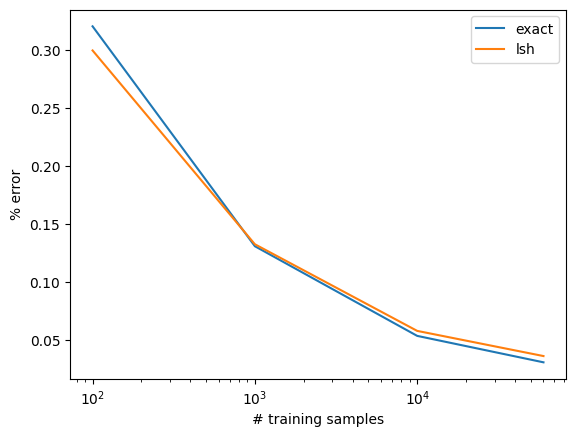

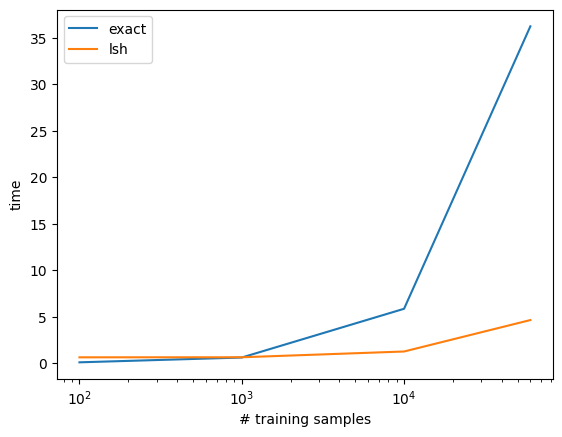

In [8]:
# 1-NN

nsample = [100, 1000, 10000, 60000]

acc_exact = []
timing_exact = []
timing_lsh = []
acc_lsh = []

for s in nsample:
  start = time.time()
  index = faiss.IndexFlatL2(x_train.shape[1])
  index.add(x_train[:s])
  dist, idx = index.search(x_test,1)
  pred = y_train[idx.squeeze()]
  acc = (pred == y_test).mean()
  acc_exact.append(acc)
  timing_exact.append(time.time() - start)

for s in nsample:
  start = time.time()
  dim = x_train.shape[1]
  index = faiss.IndexLSH(dim, dim)
  index.add(x_train[:s])
  dist, idx = index.search(x_test,1)
  pred = y_train[idx.squeeze()]
  acc = (pred == y_test).mean()
  acc_lsh.append(acc)
  timing_lsh.append(time.time() - start)

acc_exact = np.array(acc_exact)
acc_lsh = np.array(acc_lsh)

plt.semilogx(nsample, 1-acc_exact, label='exact')
plt.semilogx(nsample, 1-acc_lsh, label='lsh')
plt.legend(), plt.ylabel('% error'), plt.xlabel('# training samples')
plt.show()

plt.semilogx(nsample, timing_exact, label='exact')
plt.semilogx(nsample, timing_lsh, label='lsh')
plt.legend(), plt.ylabel('time'), plt.xlabel('# training samples')
plt.show()


In [9]:
# Confusion matrix
import sklearn
from sklearn.metrics import confusion_matrix


index = faiss.IndexFlatL2(x_train.shape[1])
index.add(x_train[:s])
dist, idx = index.search(x_test,1)
pred = y_train[idx.squeeze()]

C = confusion_matrix(y_test,pred)
print(C)
print(C[:, 2])



# TO DO

[[ 973    1    1    0    0    1    3    1    0    0]
 [   0 1129    3    0    1    1    1    0    0    0]
 [   7    6  992    5    1    0    2   16    3    0]
 [   0    1    2  970    1   19    0    7    7    3]
 [   0    7    0    0  944    0    3    5    1   22]
 [   1    1    0   12    2  860    5    1    6    4]
 [   4    2    0    0    3    5  944    0    0    0]
 [   0   14    6    2    4    0    0  992    0   10]
 [   6    1    3   14    5   13    3    4  920    5]
 [   2    5    1    6   10    5    1   11    1  967]]
[  1   3 992   2   0   0   0   6   3   1]


## Part 3: Temperature Regression

Include all your code used for part 2 in this section.  

In [7]:
import numpy as np
# from google.colab import drive
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# load data (modify to match your data directory or comment)
def load_temp_data():
  # drive.mount('/content/drive')
  # datadir = "/content/drive/My Drive/CS441/24SP/hw1/"
  datadir = "./"
  T = np.load(datadir + 'temperature_data.npz')
  x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day = \
  T['x_train'], T['y_train'], T['x_val'], T['y_val'], T['x_test'], T['y_test'], T['dates_train'], T['dates_val'], T['dates_test'], T['feature_to_city'], T['feature_to_day']
  return (x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day)

# plot one data point for listed cities and target date
def plot_temps(x, y, cities, feature_to_city, feature_to_day, target_date):
  nc = len(cities)
  ndays = 5
  xplot = np.array([-5,-4,-3,-2,-1])
  yplot = np.zeros((nc,ndays))
  for f in np.arange(len(x)):
    for c in np.arange(nc):
      if cities[c]==feature_to_city[f]:
        yplot[feature_to_day[f]+ndays,c] = x[f]
  plt.plot(xplot,yplot)
  plt.legend(cities)
  plt.plot(0, y, 'b*', markersize=10)
  plt.title('Predict Temp for Cleveland on ' + target_date)
  plt.xlabel('Day')
  plt.ylabel('Avg Temp (C)')
  plt.show()




Feature 361: city = Cleveland, day= -1
Baseline - prediction using previous day: RMSE=3.460601246750482


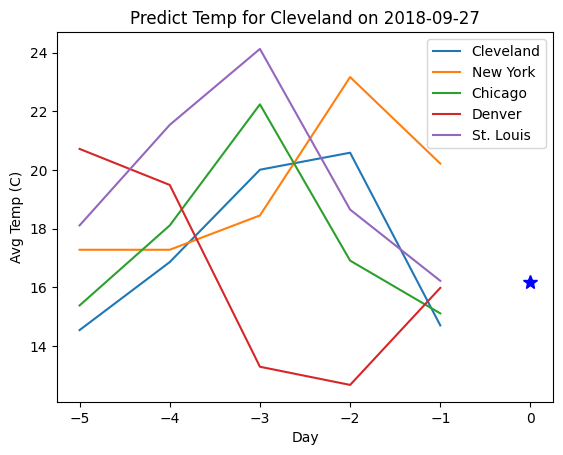

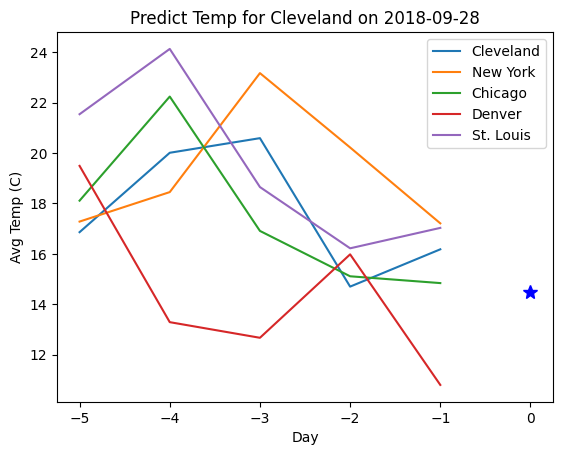

In [8]:
# load data
(x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day) = load_temp_data()
''' Data format:
      x_train, y_train: features and target value for each training sample (used to fit model)
      x_val, y_val: features and target value for each validation sample (used to select hyperparameters, such as regularization and K)
      x_test, y_test: features and target value for each test sample (used to evaluate final performance)
      dates_xxx: date of the target value for the corresponding sample
      feature_to_city: maps from a feature number to the city
      feature_to_day: maps from a feature number to a day relative to the target value, e.g. -2 means two days before
      Note: 361 is the temperature of Cleveland on the previous day
'''
f = 361
print('Feature {}: city = {}, day= {}'.format(f,feature_to_city[f], feature_to_day[f]))
baseline_rmse = np.sqrt(np.mean((y_val[1:]-y_val[:-1])**2)) # root mean squared error example
print('Baseline - prediction using previous day: RMSE={}'.format(baseline_rmse))

# plot first two x/y for val
plot_temps(x_val[0], y_val[0], ['Cleveland', 'New York', 'Chicago', 'Denver', 'St. Louis'], feature_to_city, feature_to_day, dates_val[0])
plot_temps(x_val[1], y_val[1], ['Cleveland', 'New York', 'Chicago', 'Denver', 'St. Louis'], feature_to_city, feature_to_day, dates_val[1])



In [9]:
# K-NN Regression

def regress_KNN(X_trn, y_trn, X_tst, K=1):
  '''
  Predict the target value for each data point in X_tst using a
  K-nearest neighbor regressor based on (X_trn, y_trn), with L2 distance.
  Input: X_trn[i] is the ith training data. y_trn[i] is the ith training label. K is the number of closest neighbors to use.
  Output: return y_pred, where y_pred[i] is the predicted ith test value
  '''
  index = faiss.IndexFlatL2(X_trn.shape[1])
  index.add(X_trn)
  dist, idx = index.search(X_tst,K)
  pred = y_trn[idx]
  pred = pred.mean(axis=1)
  return pred

def normalize_features(x, y, fnum):
  ''' Normalize the features in x and y.
      For each data sample i:
        x2[i] = x[i]-x[i,fnum]
        y2[i] = y[i]-x[i,fnum]
  '''
  xnorm = x - np.expand_dims(x[:,fnum],1)
  ynorm = y - x[:,fnum]
  return xnorm,ynorm
  # TO DO


k=5

# KNN with original features
y_pred = regress_KNN(x_train,y_train,x_test, K=k)
print(np.square(y_pred - y_test).mean()**0.5)
# TO DO

# KNN with normalized features
fnum = 361 # previous day temp in Cleveland

# TO DO
xnorm_train,ynorm_train = normalize_features(x_train,y_train,fnum)
xnorm_test, ynorm_test = normalize_features(x_test,y_test,fnum)


y_pred = regress_KNN(xnorm_train,ynorm_train,xnorm_test, K=k)

print(np.square(y_pred - ynorm_test).mean()**0.5)


3.249556245363484
2.9324389176041588


## Part 5: Stretch Goals
Include all your code used for part 5 in this section. You can copy-paste code from parts 1-3 if it is re-usable.

In [3]:
from scipy.stats import mode
# Stretch: KNN classification (Select K)
(x_train, y_train), (x_test, y_test) = load_mnist()

for K in [1, 3, 5, 11, 25]:
  index = faiss.IndexFlatL2(x_train.shape[1])
  index.add(x_train[:50000])
  dist, idx = index.search(x_train[50000:], K)
  pred = y_train[:50000][idx]
  mode_result, mode_count = mode(pred, axis=1)
  error = (mode_result != y_train[50000:]).mean()
  print(f"{K}: {error}")

1: 0.0288
3: 0.028
5: 0.0282
11: 0.0308
25: 0.0382


In [5]:
# test
K=3
index = faiss.IndexFlatL2(x_train.shape[1])
index.add(x_train)
dist, idx = index.search(x_test, K)
pred = y_train[idx]
mode_result, mode_count = mode(pred, axis=1)
error = (mode_result != y_test).mean()
print(f"{K}: {error}")

3: 0.0295


In [14]:
(x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day) = load_temp_data()


for k in [1, 3, 5, 11, 25]:
  print(f"k: {k}")
  # KNN with original features
  y_pred = regress_KNN(x_train,y_train,x_val, K=k)
  print(np.square(y_pred - y_val).mean()**0.5)
  
  # KNN with normalized features
  fnum = 361 # previous day temp in Cleveland
  
  xnorm_train,ynorm_train = normalize_features(x_train,y_train,fnum)
  xnorm_val, ynorm_val = normalize_features(x_val,y_val,fnum)
  
  
  y_pred = regress_KNN(xnorm_train,ynorm_train,xnorm_val, K=k)
  
  print(np.square(y_pred - ynorm_val).mean()**0.5)

print("Optimal:")
xnorm_train,ynorm_train = normalize_features(x_train,y_train,fnum)
xnorm_test, ynorm_test = normalize_features(x_test,y_test,fnum)
y_pred = regress_KNN(xnorm_train,ynorm_train,xnorm_test, K=11)
print(np.square(y_pred - ynorm_test).mean()**0.5)


k: 1
4.330006390580244
3.8669564684344615
k: 3
3.2266843182278797
3.174005914679923
k: 5
3.095887258575192
3.032493865875963
k: 11
3.055782885507432
2.8908415810941466
k: 25
3.060219056497986
2.9103974575813334
Optimal:
2.7671311757775685


In [28]:
# Stretch: K-means (more iters vs redos)
(x_train, y_train), (x_test, y_test) = load_mnist()

ps = [(20,1),(4,5),(50,1),(10,5)]
for (ni,nr) in ps:
  print(ni,nr)
  res = []
  for i in range(5):
    kmeans = faiss.Kmeans(x_train.shape[1], 30, niter=ni, nredo=nr, seed=int(i))
    kmeans.train(x_train)
    dist, idx = kmeans.index.search(x_train, 1)
    rmse = np.sqrt(np.sum(dist) / x_train.shape[0])
    res.append(rmse)
  print(np.mean(res),np.std(res))
  print()



20 1
5.786271422463997 0.007644752654037744

4 5
5.822844075465655 0.012136287784838528

50 1
5.777090880990907 0.005488117925290951

10 5
5.787613203649412 0.0037177425483455743



In [ ]:
# from https://gist.github.com/jonathanagustin/b67b97ef12c53a8dec27b343dca4abba
# For use in Colab.  For local, just use jupyter nbconvert directly

import os
# @title Convert Notebook to PDF. Save Notebook to given directory
NOTEBOOKS_DIR = "/content/drive/My Drive/CS441/24SP/hw1" # @param {type:"string"}
NOTEBOOK_NAME = "CS441_SP24_HW1_Solution.ipynb" # @param {type:"string"}
#------------------------------------------------------------------------------#
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
NOTEBOOK_PATH = f"{NOTEBOOKS_DIR}/{NOTEBOOK_NAME}"
assert os.path.exists(NOTEBOOK_PATH), f"NOTEBOOK NOT FOUND: {NOTEBOOK_PATH}"
!apt install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic > /dev/null 2>&1
!jupyter nbconvert "$NOTEBOOK_PATH" --to pdf > /dev/null 2>&1
NOTEBOOK_PDF = NOTEBOOK_PATH.rsplit('.', 1)[0] + '.pdf'
assert os.path.exists(NOTEBOOK_PDF), f"ERROR MAKING PDF: {NOTEBOOK_PDF}"
print(f"PDF CREATED: {NOTEBOOK_PDF}")